# Transfer Learning

In this notebook, you'll learn how to use pre-trained networks to solved challenging problems in computer vision. Specifically, you'll use networks trained on [ImageNet](http://www.image-net.org/) [available from torchvision](http://pytorch.org/docs/0.3.0/torchvision/models.html). 

ImageNet is a massive dataset with over 1 million labeled images in 1000 categories. It's used to train deep neural networks using an architecture called convolutional layers. I'm not going to get into the details of convolutional networks here, but if you want to learn more about them, please [watch this](https://www.youtube.com/watch?v=2-Ol7ZB0MmU).

Once trained, these models work astonishingly well as feature detectors for images they weren't trained on. Using a pre-trained network on images not in the training set is called transfer learning. Here we'll use transfer learning to train a network that can classify our cat and dog photos with near perfect accuracy.

With `torchvision.models` you can download these pre-trained networks and use them in your applications. We'll include `models` in our imports now.

In [7]:
#
# fix for AWS SageMaker
#
# add missing packages
#
!conda install -c conda-forge ipywidgets -y
!jupyter nbextension enable --py widgetsnbextension
#
# Restart kernel
#

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.1
  latest version: 4.10.3

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - ipywidgets


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    argon2-cffi-20.1.0         |   py36h1d69622_2          47 KB  conda-forge
    attrs-21.2.0               |     pyhd8ed1ab_0          44 KB  conda-forge
    bleach-3.3.1               |     pyhd8ed1ab_0         111 KB  conda-forge
    ca-certificates-2021.5.30  |       ha878542_0         136 KB  conda-forge
    certifi-2021.5.30          |   py36h5fab9bb_0         141 KB  conda-forge
    conda-4.10.3               |   py36h5fab9bb_0         3.1 MB  conda-forge
    defusedxml-0.7.1           |     pyhd8ed1ab_0          23 KB  conda-forge


In [1]:
#
# fix for MacOS 
#
# from https://stackoverflow.com/questions/53014306/error-15-initializing-libiomp5-dylib-but-found-libiomp5-dylib-already-initial
#

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

Most of the pretrained models require the input to be 224x224 images. Also, we'll need to match the normalization used when the models were trained. Each color channel was normalized separately, the means are `[0.485, 0.456, 0.406]` and the standard deviations are `[0.229, 0.224, 0.225]`.

In [3]:
data_dir = 'Cat_Dog_data'

# TODO: Define transforms for the training data and testing data
train_transforms = transforms.Compose([
                        transforms.RandomRotation(30),
                        transforms.RandomResizedCrop(224),
                        transforms.RandomHorizontalFlip(),
                        transforms.ToTensor()
                        ])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor()])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

We can load in a model such as [DenseNet](http://pytorch.org/docs/0.3.0/torchvision/models.html#id5). Let's print out the model architecture so we can see what's going on.

In [4]:
model = models.densenet121(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [5]:
model.classifier

Linear(in_features=1024, out_features=1000, bias=True)

This model is built out of two main parts, the features and the classifier. The features part is a stack of convolutional layers and overall works as a feature detector that can be fed into a classifier. The classifier part is a single fully-connected layer `(classifier): Linear(in_features=1024, out_features=1000)`. This layer was trained on the ImageNet dataset, so it won't work for our specific problem. That means we need to replace the classifier, but the features will work perfectly on their own. In general, I think about pre-trained networks as amazingly good feature detectors that can be used as the input for simple feed-forward classifiers.

In [6]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 500)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(500, 2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.classifier = classifier

In [7]:
model.classifier

Sequential(
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=500, out_features=2, bias=True)
  (output): LogSoftmax(dim=1)
)

With our model built, we need to train the classifier. However, now we're using a **really deep** neural network. If you try to train this on a CPU like normal, it will take a long, long time. Instead, we're going to use the GPU to do the calculations. The linear algebra computations are done in parallel on the GPU leading to 100x increased training speeds. It's also possible to train on multiple GPUs, further decreasing training time.

PyTorch, along with pretty much every other deep learning framework, uses [CUDA](https://developer.nvidia.com/cuda-zone) to efficiently compute the forward and backwards passes on the GPU. In PyTorch, you move your model parameters and other tensors to the GPU memory using `model.to('cuda')`. You can move them back from the GPU with `model.to('cpu')` which you'll commonly do when you need to operate on the network output outside of PyTorch. As a demonstration of the increased speed, I'll compare how long it takes to perform a forward and backward pass with and without a GPU.

In [8]:
import time

In [9]:
torch.cuda.is_available()

True

In [10]:
for device in ['cpu', 'cuda']:

    criterion = nn.NLLLoss()
    # Only train the classifier parameters, feature parameters are frozen
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

    model.to(device)

    for ii, (inputs, labels) in enumerate(trainloader):

        # Move input and label tensors to the GPU
        inputs, labels = inputs.to(device), labels.to(device)

        start = time.time()

        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if ii==3:
            break
        
    print(f"Device = {device}; Time per batch: {(time.time() - start)/3:.3f} seconds")

[2021-07-25 13:02:07.219 pytorch-1-6-gpu-py3-ml-g4dn-xlarge-4bc1f3597a3fd3d3d1e8cfe2e695:2861 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-07-25 13:02:07.256 pytorch-1-6-gpu-py3-ml-g4dn-xlarge-4bc1f3597a3fd3d3d1e8cfe2e695:2861 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
Device = cpu; Time per batch: 2.442 seconds
Device = cuda; Time per batch: 0.017 seconds


You can write device agnostic code which will automatically use CUDA if it's enabled like so:
```python
# at beginning of the script
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

...

# then whenever you get a new Tensor or Module
# this won't copy if they are already on the desired device
input = data.to(device)
model = MyModule(...).to(device)
```

From here, I'll let you finish training the model. The process is the same as before except now your model is much more powerful. You should get better than 95% accuracy easily.

>**Exercise:** Train a pretrained models to classify the cat and dog images. Continue with the DenseNet model, or try ResNet, it's also a good model to try out first. Make sure you are only training the classifier and the parameters for the features part are frozen.

In [11]:
## TODO: Use a pretrained model to classify the cat and dog images

In [12]:
device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device={device}")

Device=cuda


In [13]:
# load pretrained model
model = models.resnet50(pretrained=True)
# freese paaremters
for param in model.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [14]:
#replace classifier
classifier = nn.Sequential(
                    nn.Linear(2048,512),
                    nn.ReLU(),
                    nn.Dropout(p=0.2),
                    nn.Linear(512,2),
                    nn.LogSoftmax(dim=1)
                )
model.fc = classifier
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [15]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [17]:
## TODO: Use a pretrained model to classify the cat and dog images


model.to(device)


epochs = 1
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    start = time.time()
    batch = 0
    for images, labels in trainloader:
        
        # Move input and label tensors to the GPU or CPU
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()  #prepare gradients for a new step
        
        log_ps = model(images)   # make a forward step.
        loss = criterion(log_ps, labels)  # calcualte loss function
        loss.backward()       # make a backstep on loss value
        optimizer.step()      # recalculate network weights
        
        running_loss += loss.item()
        batch += 1
        
        print("Epoch {}/{}".format(e+1,epochs),
              "Batch {}/{}".format(batch,len(trainloader)),
              "Train loss {:.3f}".format(running_loss/batch),
              "Time per batch: {:.3f} seconds".format((time.time() - start)/batch)
             )

        
    else:
        print(f"Epoch {e} Running loss {running_loss/len(trainloader)}")
        
        train_losses.append(running_loss/len(trainloader))
        
        ## TODO: Implement the validation pass and print out the validation accuracy
        accuracy = 0
        test_loss = 0 
        
        model.eval() #enter inference mode wiout dropout
        
        for images, labels in testloader:
            # Move input and label tensors to the GPU or CPU
            images, labels = images.to(device), labels.to(device)
            
            with torch.no_grad():
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p,top_class = ps.topk(1,dim=1)
                equal = (top_class == labels.view(*top_class.shape))
                accuracy += (torch.mean(equal.type(torch.FloatTensor)))
                
        test_losses.append(test_loss/len(testloader))
        
        model.train() # return to a training mode with dropout

        print("Epoch {}/{}".format(e+1,epochs),
              "Train loss {:.3f}".format(running_loss/len(trainloader)),
              "Test  loss {:.3f}".format(test_loss/len(testloader)),
              "Accuracy   {:.3f}".format(accuracy/len(testloader)))
        

Epoch 1/1 Batch 1/278 Train loss 0.662 Time per batch: 0.899 seconds
Epoch 1/1 Batch 2/278 Train loss 1.479 Time per batch: 0.851 seconds
Epoch 1/1 Batch 3/278 Train loss 1.181 Time per batch: 0.836 seconds
Epoch 1/1 Batch 4/278 Train loss 1.068 Time per batch: 0.824 seconds
Epoch 1/1 Batch 5/278 Train loss 1.089 Time per batch: 0.819 seconds
Epoch 1/1 Batch 6/278 Train loss 1.111 Time per batch: 0.812 seconds
Epoch 1/1 Batch 7/278 Train loss 1.053 Time per batch: 0.810 seconds
Epoch 1/1 Batch 8/278 Train loss 0.988 Time per batch: 0.809 seconds
Epoch 1/1 Batch 9/278 Train loss 0.937 Time per batch: 0.807 seconds
Epoch 1/1 Batch 10/278 Train loss 0.908 Time per batch: 0.804 seconds
Epoch 1/1 Batch 11/278 Train loss 0.901 Time per batch: 0.800 seconds
Epoch 1/1 Batch 12/278 Train loss 0.879 Time per batch: 0.798 seconds
Epoch 1/1 Batch 13/278 Train loss 0.850 Time per batch: 0.798 seconds
Epoch 1/1 Batch 14/278 Train loss 0.821 Time per batch: 0.800 seconds
Epoch 1/1 Batch 15/278 Train 

In [18]:
torch.save(model.state_dict(), 'cat_dog_checkpoint.pth')

tensor(0)


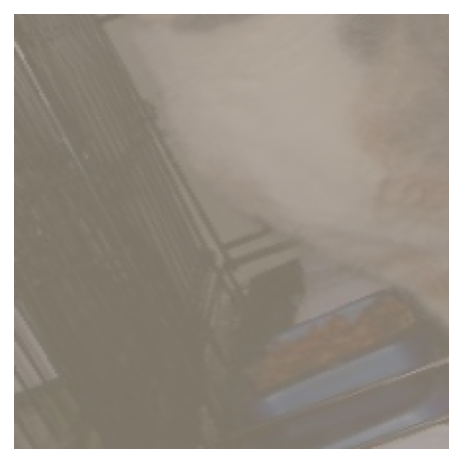

In [23]:
import helper
image, label = next(iter(trainloader))
print(label[0])
helper.imshow(image[0,:]);

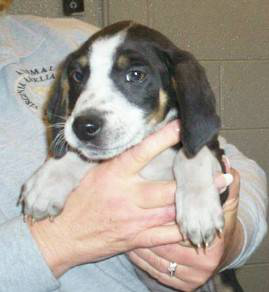

In [66]:
import PIL

#image = PIL.Image.open('assets/cat.70.jpg')
#image = PIL.Image.open('assets/dog.128.jpg')
image = PIL.Image.open('Cat_Dog_data/test/dog/dog.10.jpg')
image

Class 1 prob 1.000


<AxesSubplot:>

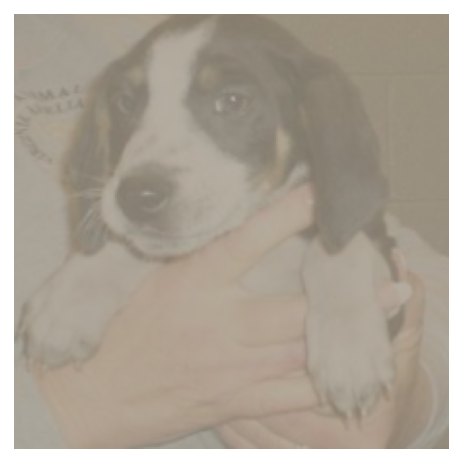

In [67]:
t = test_transforms(image)
model.eval()
log_ps = model(t.unsqueeze(0).to(device))
ps = torch.exp(log_ps)
top_p,top_class = ps.topk(1,dim=1)
print("Class {} prob {:.03f}".format(top_class.item(),top_p.item()))
helper.imshow(t)

In [82]:
torch.exp(log_ps).detach().cpu().squeeze().numpy()

array([2.5845747e-04, 9.9974149e-01], dtype=float32)

In [ ]:
plt.plot(train_losses,label="Training loss")
plt.plot(test_losses,label="Test loss")
plt.legend(frameon=False)